In [3]:
import pandas as pd
import psycopg2
import sqlalchemy
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from datetime import date
from platform import python_version
print(python_version())

3.7.12


Holt-Winters Exponential Smoothing is used for forecasting time series data that exhibits both a trend and a seasonal variation.

In [4]:
connection = psycopg2.connect(
    host = 'teamev.c5ap8dqhexya.us-east-1.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = 'dogecoin',
    database='postgres'
    )
cursor=connection.cursor()

sql = """
SELECT * FROM maclea; 
"""

df = pd.read_sql(sql, con=connection)
# Loading Data
# df = pd.read_sql_table('monthly_sales', con=connection)
# file_path = "<insert_file_path_right_here"
# df = pd.read_csv(file_path)
df.head(10)

,month,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations,elecv_totals,hybrid_totals
0,2012-01-01,1257.0,0.128,3.380,4,4,2057.0,652.0,605.0
1,2012-02-01,1566.0,0.128,3.579,4,4,2130.0,522.0,1044.0
2,2012-03-01,3815.0,0.127,3.852,4,4,2213.0,635.0,3180.0
3,2012-04-01,3565.0,0.127,3.900,4,4,2273.0,449.0,3116.0
4,2012-05-01,3367.0,0.129,3.732,5,5,2367.0,595.0,2772.0
5,2012-06-01,2524.0,0.135,3.539,6,6,2439.0,580.0,1944.0
6,2012-07-01,3029.0,0.133,3.439,7,7,2497.0,454.0,2575.0
7,2012-08-01,4686.0,0.133,3.722,7,7,2550.0,774.0,3912.0
8,2012-09-01,5745.0,0.133,3.849,8,7,2576.0,1183.0,4562.0
9,2012-10-01,7084.0,0.128,3.746,9,7,2771.0,1972.0,5112.0


In [5]:
df.dtypes

month              object
total_ev          float64
elec_price        float64
gas_price         float64
model_id_count      int64
brand_id_count      int64
ev_stations       float64
elecv_totals      float64
hybrid_totals     float64
dtype: object

In [6]:
# Change 'month' datatype to date

df['month']= pd.to_datetime(df['month'])

In [7]:
df = df.sort_values(by=['month'])
df

,month,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations,elecv_totals,hybrid_totals
0,2012-01-01,1257.0,0.128,3.380,4,4,2057.0,652.0,605.0
1,2012-02-01,1566.0,0.128,3.579,4,4,2130.0,522.0,1044.0
2,2012-03-01,3815.0,0.127,3.852,4,4,2213.0,635.0,3180.0
3,2012-04-01,3565.0,0.127,3.900,4,4,2273.0,449.0,3116.0
4,2012-05-01,3367.0,0.129,3.732,5,5,2367.0,595.0,2772.0
...,...,...,...,...,...,...,...,...,...
91,2019-08-01,26455.0,0.139,2.621,40,22,15982.0,19522.0,6933.0
92,2019-09-01,31833.0,0.139,2.592,39,22,16600.0,26422.0,5411.0
93,2019-10-01,8665.0,0.136,2.627,32,16,16926.0,3509.0,5156.0
94,2019-11-01,10180.0,0.133,2.598,30,15,17280.0,4307.0,5873.0


In [8]:
df['month'] = df['month'].apply(lambda x: x.strftime("%m-%d-%Y"))
df

,month,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations,elecv_totals,hybrid_totals
0,01-01-2012,1257.0,0.128,3.380,4,4,2057.0,652.0,605.0
1,02-01-2012,1566.0,0.128,3.579,4,4,2130.0,522.0,1044.0
2,03-01-2012,3815.0,0.127,3.852,4,4,2213.0,635.0,3180.0
3,04-01-2012,3565.0,0.127,3.900,4,4,2273.0,449.0,3116.0
4,05-01-2012,3367.0,0.129,3.732,5,5,2367.0,595.0,2772.0
...,...,...,...,...,...,...,...,...,...
91,08-01-2019,26455.0,0.139,2.621,40,22,15982.0,19522.0,6933.0
92,09-01-2019,31833.0,0.139,2.592,39,22,16600.0,26422.0,5411.0
93,10-01-2019,8665.0,0.136,2.627,32,16,16926.0,3509.0,5156.0
94,11-01-2019,10180.0,0.133,2.598,30,15,17280.0,4307.0,5873.0


In [9]:
# Set 'month' to be the index

df = df.set_index('month')
df

,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations,elecv_totals,hybrid_totals
month,,,,,,,,
01-01-2012,1257.0,0.128,3.380,4,4,2057.0,652.0,605.0
02-01-2012,1566.0,0.128,3.579,4,4,2130.0,522.0,1044.0
03-01-2012,3815.0,0.127,3.852,4,4,2213.0,635.0,3180.0
04-01-2012,3565.0,0.127,3.900,4,4,2273.0,449.0,3116.0
05-01-2012,3367.0,0.129,3.732,5,5,2367.0,595.0,2772.0
...,...,...,...,...,...,...,...,...
08-01-2019,26455.0,0.139,2.621,40,22,15982.0,19522.0,6933.0
09-01-2019,31833.0,0.139,2.592,39,22,16600.0,26422.0,5411.0
10-01-2019,8665.0,0.136,2.627,32,16,16926.0,3509.0,5156.0


In [10]:
# Set the index frequency explicitly to Monthly so that statsmodels does not have
# to try to infer it

df.index.freq = 'MS'

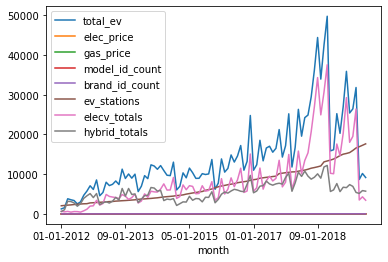

In [11]:
df.plot()
plt.show()

In [17]:
# Split between the training and the test data sets.
# The last 12 periods form the test data.

df_train = df['hybrid_totals'].iloc[:-12]
df_test = df['hybrid_totals'].iloc[-12:]

In [18]:
# Build and train the model on the training data. In the above chart, the level
# of the time series seems to be increasing linearly. So we set the trend as additive.
# However, the seasonal variation around each level seems to be increasing in
# proportion to the current level. So we set the seasonality to multiplicative.

model = HWES(df_train, seasonal_periods=12, trend='add', seasonal='add')
fitted = model.fit()

/Users/matthew_kleineck/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
print(fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:            hybrid_totals   No. Observations:                   84
Model:             ExponentialSmoothing   SSE                       63313460.460
Optimized:                         True   AIC                           1168.755
Trend:                         Additive   BIC                           1207.648
Seasonal:                      Additive   AICC                          1179.278
Seasonal Periods:                    12   Date:                 Wed, 30 Mar 2022
Box-Cox:                          False   Time:                         18:42:28
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5664134                alpha                 True
smoothing_trend          

In [20]:
sales_forecast = fitted.forecast(steps=12)


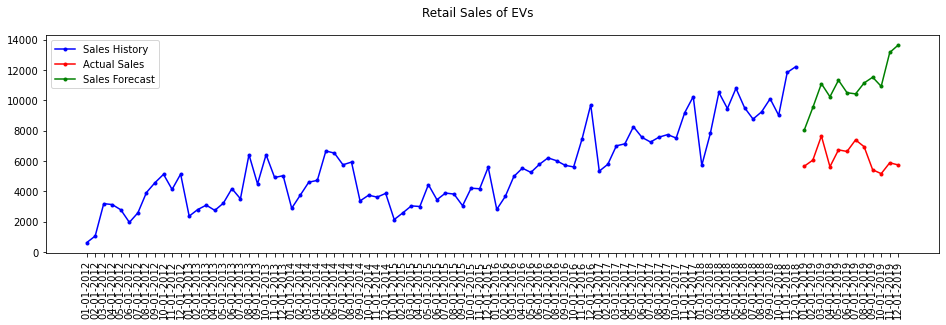

In [21]:
fig = plt.figure(figsize=(16,4))
fig.suptitle('Retail Sales of EVs')
past, = plt.plot(df_train.index, df_train, 'b.-', label='Sales History')
future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Sales')
predicted_future, = plt.plot(df_test.index, sales_forecast, 'g.-', label='Sales Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.xticks(rotation=90)
plt.show()